# Testing for multiple runs

PIT tests for each inferred parameter and reconstruction of non-parametric $\rho(r)$

In [116]:
import numpy as np
import math
import pandas as pd
from scipy import integrate, optimize
import scipy as sp
import numpyro
import numpyro.distributions as dist
from jax import random, jit
from jax import numpy as jnp
from jax import vmap
from jaxopt import Bisection
import matplotlib.pyplot as plt
import seaborn as sns
import corner
import arviz as az
from scipy.special import gammaincinv
from jax.scipy.special import gamma, gammaincc, gammainc
from scipy.interpolate import interp1d
import pickle
import sys
import functions.dkw_tarp as dkw_tarp
import functions.dkw_pit as dkw_pit
from numpyro.diagnostics import hpdi


### Data handling functions

In [117]:
def samples_dict_to_array(samples_dict):
    """
    Convert a NumPyro samples dictionary to a 2D numpy array of shape (num_samples, num_runs).
    """
    arrays = []
    for param in samples_dict.values():
        # Flatten each sample: shape (num_samples, param_dims...)
        param_flat = param.reshape(param.shape[0], -1)
        arrays.append(param_flat)
    
    # Concatenate all parameter arrays along axis 1
    return np.concatenate(arrays, axis=1)


def samples_dict_to_array_nodes(samples_dict):
    """
    Converts dictionary to 3D numpy array of shape (num_samples, num_runs, num_nodes)
    """
    keys = list(samples_dict.keys())
    
    arr = np.stack([samples_dict[k] for k in keys], axis=0)
    arr = np.transpose(arr, (2, 0, 1, 3))
    
    num_draws, num_cores, n_chains, num_nodes = arr.shape
    
    return arr.reshape(num_draws, num_cores * n_chains, num_nodes)


def truths_list(truths):
    
    output = []
    
    for i in range(len(truths)):
        output += truths[i]
    
    return output

def truths_nodes(truths):
    """
    truths_dict_values: something like f_pts_truth_list.values()
      - length n_runs
      - each element is [Array(11,)] (list of length 1)

    returns: (n_runs, n_components) np.ndarray
    """
    blocks = []
    for item in truths:
        # item is a list like [Array(11,)]
        arr = np.asarray(item)   # grab the Array(11,)
        blocks.append(arr)
    return np.concatenate(blocks, axis=0) 

def f_of_r(r, f_pts):
    """
    Interpolates f(r) for given spline points (f_pts)

    """
    
    # clip r to ensure within min/max of r_points
    r_clipped = jnp.clip(r, r_points[0], r_points[-1])
    return jnp.interp(r_clipped, r_points, f_pts)

### Load data

In [118]:
with open("data/numerical_schechter_nonpara_100trial_40kgals.pkl", "rb") as f:
    MPI_master = pickle.load(f)



alpha_dict = MPI_master['alpha']
L_star_dict = MPI_master['M_star']
phi_star_dict = MPI_master['phi_star']
f_pts_dict = MPI_master['rho_pts']
sm_dict = MPI_master['shell_mass']

alpha_truth_list = MPI_master['alpha_truth']
L_star_truth_list = MPI_master['M_star_truth']
f_pts_truth_list = MPI_master['rho_pts_truth']
sm_truth_list = MPI_master['shell_mass_truth']

# convert dict to array
alpha_array = samples_dict_to_array(alpha_dict)
L_star_array = samples_dict_to_array(L_star_dict)
phi_star_array = samples_dict_to_array(phi_star_dict)
f_array = samples_dict_to_array_nodes(f_pts_dict)
sm_array = samples_dict_to_array_nodes(sm_dict)

alpha_truth_array = truths_list(alpha_truth_list)
L_star_truth_array = truths_list(L_star_truth_list)
f_truth_array = truths_nodes(f_pts_truth_list.values())
sm_truth_array = truths_nodes(sm_truth_list.values())

In [119]:
np.shape(f_array)

(1001, 100, 11)

### PIT tests on Schechter params

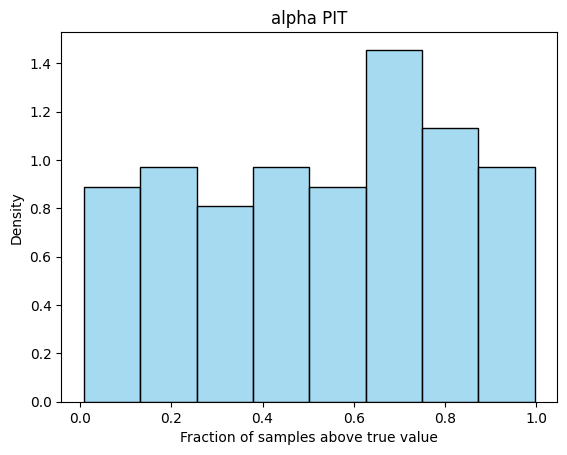

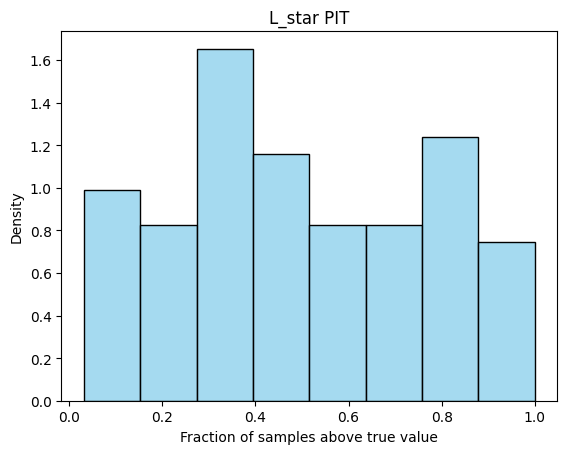

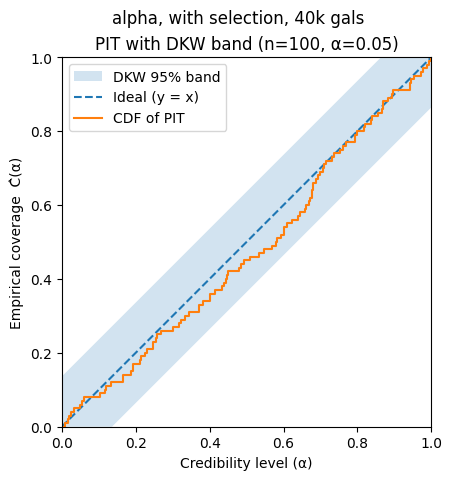

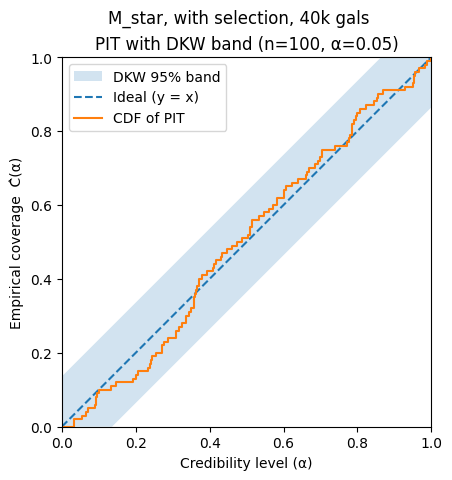

In [120]:
f_alpha = alpha_array

frac_alpha = np.mean(f_alpha > alpha_truth_array, axis=0)

sns.histplot(frac_alpha, bins='auto', stat='density', color='skyblue')
plt.xlabel('Fraction of samples above true value')
plt.title("alpha PIT")
plt.show()


f_L_star = L_star_array

frac_L_star = np.mean(f_L_star > L_star_truth_array, axis=0)

sns.histplot(frac_L_star, bins='auto', stat='density', color='skyblue')
plt.xlabel('Fraction of samples above true value')
plt.title("L_star PIT")
plt.show()


for i, j in zip((frac_alpha, frac_L_star), ('alpha', 'M_star')):
    dkw_pit.plot_pit_with_dkw(i, alpha=0.05)
    plt.suptitle(f"{j}, with selection, 40k gals")
    plt.show()

# PIT tests on $\rho$ nodes

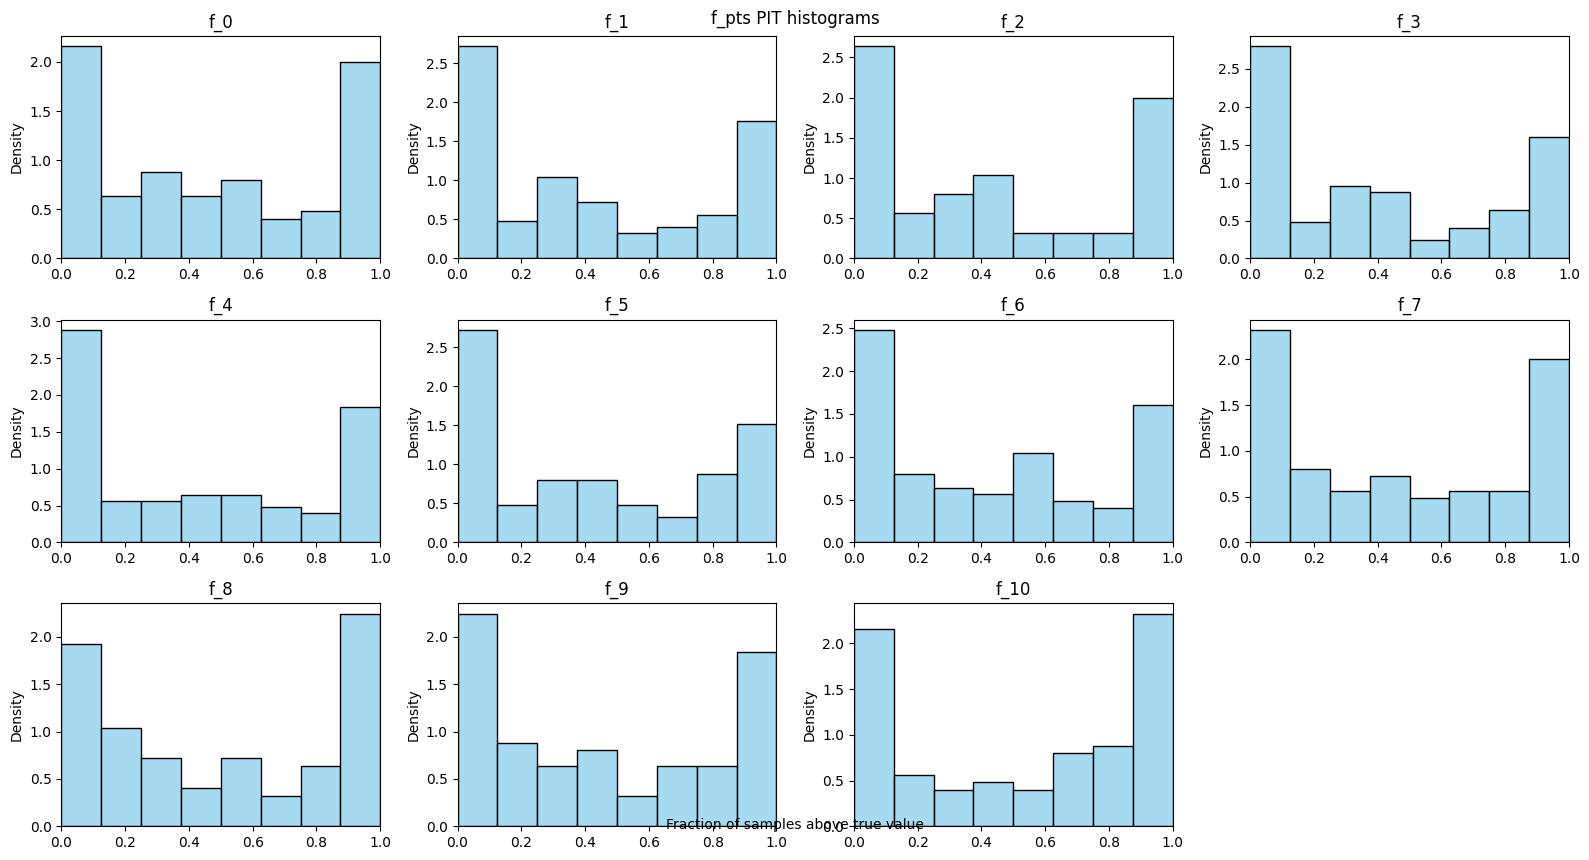

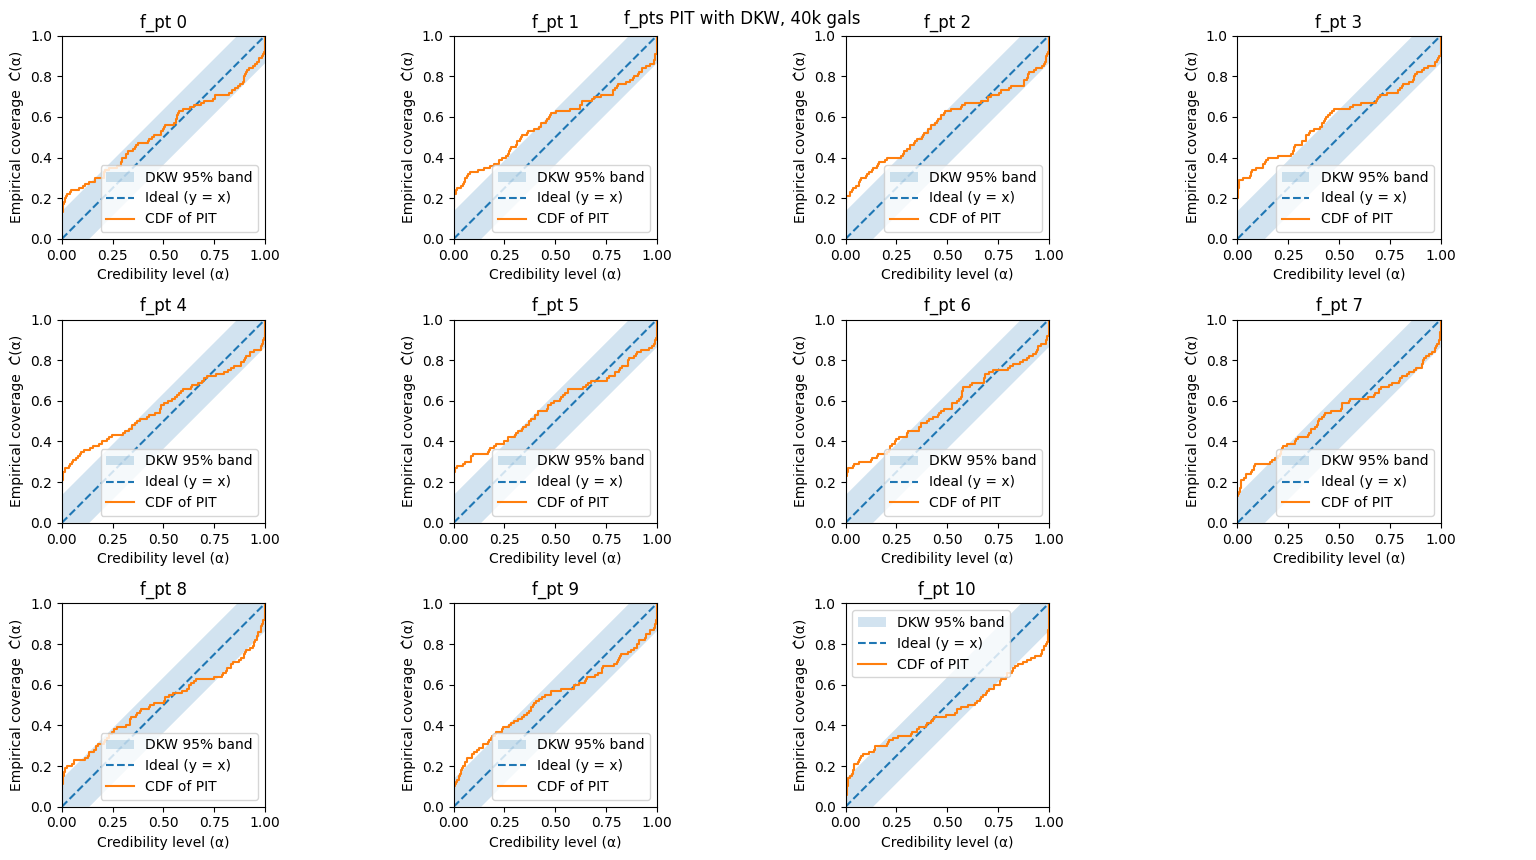

In [124]:
frac_f = np.mean(f_array > f_truth_array[None, :, :], axis=0)

n_runs, n_fpts = frac_f.shape

ncols = 4
nrows = math.ceil(n_fpts / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)

for k in range(n_fpts):
    r = k // ncols
    c = k % ncols
    ax = axes[r, c]
    sns.histplot(frac_f[:, k], bins='auto', stat='density', color='skyblue', ax=ax)
    ax.set_xlim(0, 1)
    ax.set_xlabel('')
    ax.set_title(f"f_{k}")

# Hide any unused subplots
for k in range(n_fpts, nrows*ncols):
    r = k // ncols
    c = k % ncols
    axes[r, c].axis('off')

fig.suptitle("f_pts PIT histograms", y=0.95)
fig.text(0.5, 0.04, 'Fraction of samples above true value', ha='center')
plt.tight_layout()
plt.show()


n_runs, n_fpts = frac_f.shape

ncols = 4
nrows = math.ceil(n_fpts / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)

for k in range(n_fpts):
    r, c = divmod(k, ncols)
    ax = axes[r, c]

    # Make this the "current" axes so your function draws here
    

    # Call your existing PIT plotting function on this column
    dkw_pit.plot_pit_with_dkw(frac_f[:, k], alpha=0.05, ax=ax)

    ax.set_title(f"f_pt {k}")

# Hide unused subplots if n_fpts doesn’t fill the grid
for k in range(n_fpts, nrows * ncols):
    r, c = divmod(k, ncols)
    axes[r, c].axis("off")

fig.suptitle("f_pts PIT with DKW, 40k gals", y=0.95)
plt.tight_layout()
plt.show()


### $ln(\rho(r))$ reconstructions

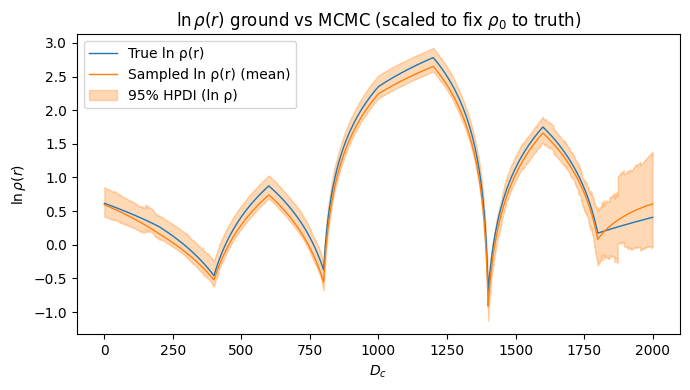

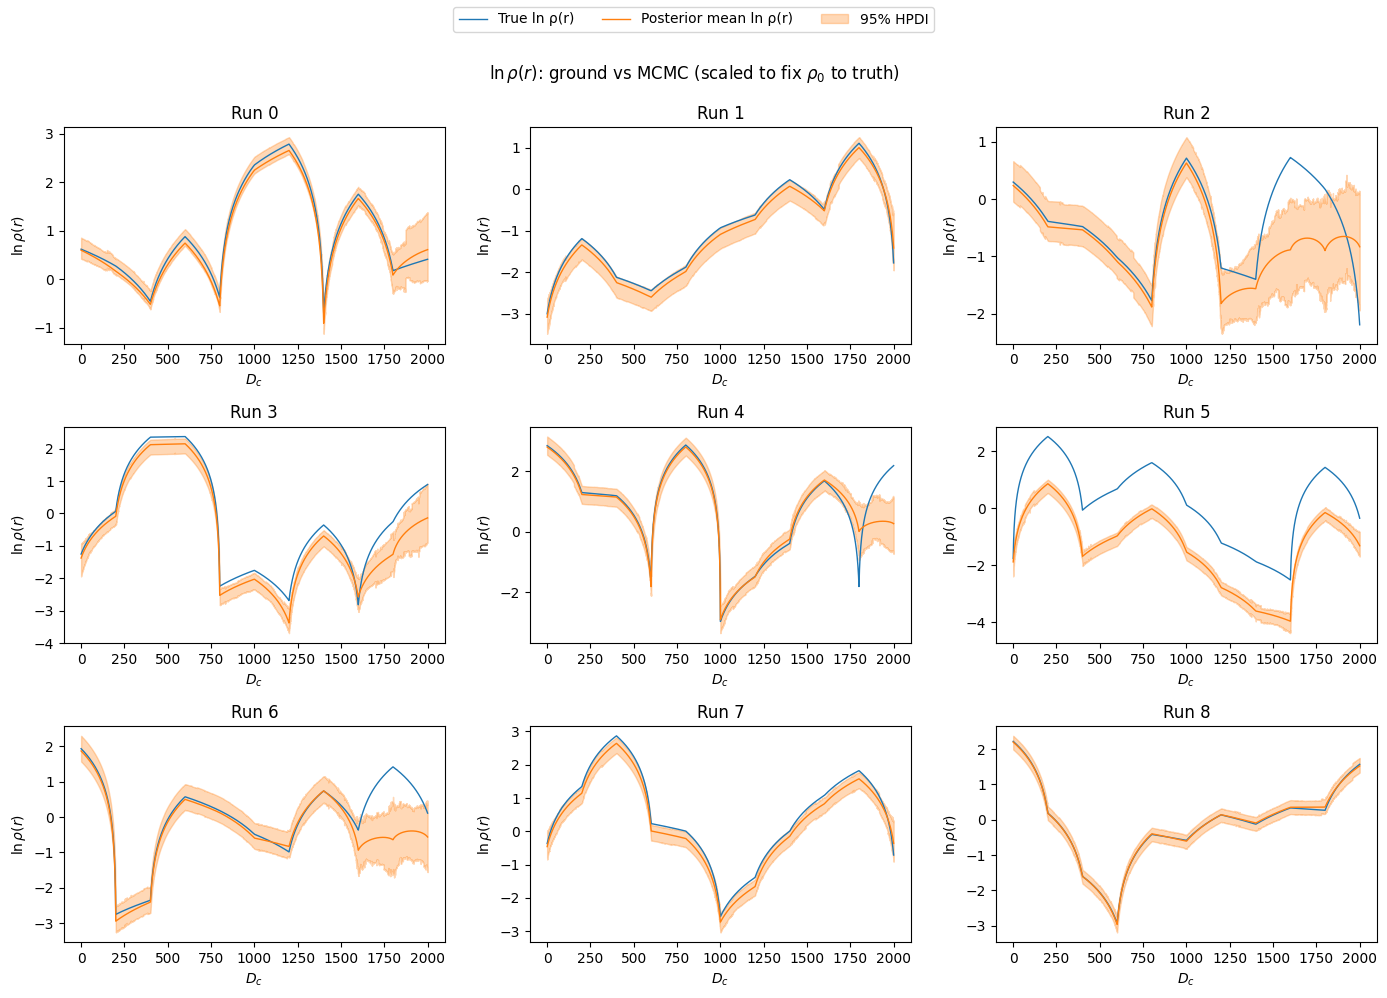

In [122]:
## scaling
scaling = f_truth_array[:,0] / jnp.mean(f_array[:,:,0], axis=0)
f_scaled_array = f_array.copy() * scaling[None, :, None]

dc_max = 2000
##  ln(rho(r)) reconstruction

n_splines = 11

r_points = np.linspace(0, dc_max, n_splines)

# Posterior samples of the spline control points
# shape: (n_samples, n_splines)
f_samps = f_array[:, 0, :]

scaling = f_truth_array[0, 0] / jnp.mean(f_samps[:, 0])

f_samps = f_samps * scaling

r_vals = jnp.linspace(0, dc_max, 10000)

# Convert to JAX
f_samps_jax = jnp.array(f_samps)
r_vals_jax  = jnp.array(r_vals)

# Evaluate rho(r) on r_vals for each posterior sample
f_vals_samps = vmap(lambda f_pts: f_of_r(r_vals_jax, f_pts))(f_samps_jax)


eps = 1e-30
log_f_vals_samps = jnp.log(f_vals_samps + eps)

# Posterior mean and 95% HPDI in log space
log_fmean = jnp.mean(log_f_vals_samps, axis=0)
log_hpdi  = hpdi(log_f_vals_samps, prob=0.68)

# Convert to numpy for plotting
log_fmean_np   = np.array(log_fmean)
log_hpdi_low   = np.array(log_hpdi[0])
log_hpdi_high  = np.array(log_hpdi[1])

# True profile in log-space
f_vals_ground = f_of_r(r_vals, f_truth_array[0, :])
log_f_ground  = np.log(f_vals_ground + eps)

# Plot ln rho(r) vs r
plt.figure(figsize=(7, 4))

plt.plot(r_vals, log_f_ground, label='True ln ρ(r)', color='C0', lw=1)
plt.plot(r_vals, log_fmean_np, label='Sampled ln ρ(r) (mean)', color='C1', lw=1)

plt.fill_between(
    r_vals,
    log_hpdi_low,
    log_hpdi_high,
    color='C1',
    alpha=0.3,
    interpolate=True,
    label='95% HPDI (ln ρ)'
)

plt.title(r"$\ln \rho(r)$ ground vs MCMC (scaled to fix $\rho_0$ to truth)")
plt.xlabel(r'$D_c$')
plt.ylabel(r'$\ln \rho(r)$')
plt.legend()
plt.tight_layout()
plt.show()


n_panels = 9
ncols = 3
nrows = 3

r_vals = jnp.linspace(0, dc_max, 10000)
eps = 1e-30

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 10), squeeze=False)

for run in range(n_panels):
    ax = axes[run // ncols, run % ncols]

    # --- samples for this run ---
    f_samps = f_array[:, run, :]                 # (n_samples, 11)
    
    scaling = f_truth_array[run, 0] / jnp.mean(f_samps[:, 0])
    f_samps = f_samps * scaling
    
    f_samps_jax = jnp.array(f_samps)

    # Evaluate rho(r) for each posterior sample: (n_samples, n_r)
    f_vals_samps = vmap(lambda f_pts: f_of_r(r_vals, f_pts))(f_samps_jax)

    # log space summaries
    log_f_vals_samps = jnp.log(f_vals_samps + eps)
    log_fmean = jnp.mean(log_f_vals_samps, axis=0)         # (n_r,)
    log_hpdi  = hpdi(log_f_vals_samps, prob=0.68)          # (2, n_r)

    # to numpy for plotting
    log_fmean_np  = np.array(log_fmean)
    log_hpdi_low  = np.array(log_hpdi[0])
    log_hpdi_high = np.array(log_hpdi[1])

    # --- truth for this run ---
    f_vals_ground = np.array(f_of_r(np.array(r_vals), f_truth_array[run, :]))
    log_f_ground  = np.log(f_vals_ground + eps)

    r_np = np.array(r_vals)

    # --- plot into this axis ---
    ax.plot(r_np, log_f_ground, lw=1, color='C0', label="True ln ρ(r)")
    ax.plot(r_np, log_fmean_np, lw=1, color='C1', label="Posterior mean ln ρ(r)")
    ax.fill_between(r_np, log_hpdi_low, log_hpdi_high, alpha=0.3, color='C1', label="95% HPDI")

    ax.set_title(f"Run {run}")
    ax.set_xlabel(r"$D_c$")
    ax.set_ylabel(r"$\ln \rho(r)$")

# Put one legend for the whole figure
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3)

fig.suptitle(r"$\ln \rho(r)$: ground vs MCMC (scaled to fix $\rho_0$ to truth)", y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()